# Predicting Survival  on Titanic Disaster

## Import Necessary Libraries 

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
sns.set()
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import KFold
import itertools
from sklearn.linear_model import LogisticRegression

## Reading and Cleaning the  Data

In [2]:
# Load training and test data
train = pd.read_csv('../input/titanic/train.csv')
test = pd.read_csv('../input/titanic/test.csv')

# Separate response variable and explanatory variable
train_x = train.drop(['Survived'], axis=1)
train_y = train['Survived']

# Copy test data which only contains explanatory variable
test_x = test.copy()

In [3]:
# Remove 'PassengerId' - not required for prediction
train_x = train_x.drop(['PassengerId'], axis=1)
test_x = test_x.drop(['PassengerId'], axis=1)

# Remove other variables not used for prediction
train_x = train_x.drop(['Name', 'Ticket', 'Cabin'], axis=1)
test_x = test_x.drop(['Name', 'Ticket', 'Cabin'], axis=1)

# Label encode categorical variables
for cat_col in ['Sex', 'Embarked']:
    # Determine how to Label Encode base don trainig data
    le = LabelEncoder()
    le.fit(train_x[cat_col].fillna('NA'))
    
    # Transform the training and testing data
    train_x[cat_col] = le.transform(train[cat_col].fillna('NA'))
    test_x[cat_col] = le.transform(test[cat_col].fillna('NA'))

In [4]:
# List to store k-fold scores
scores_accuracy = []
scores_logloss = []

# Apply cross-validation
# Apply k-fold by breaking training data into 4 blocks
kf = KFold(n_splits=4, shuffle=True, random_state=71)
for tr_idx, va_idx in kf.split(train_x):
    # Separate train_x into training data and validation data
    tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
    tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]
    
    #Apply machine learning model
    model = XGBClassifier(eta=0.05, n_estimators=999,early_stopping_rounds=200, random_state=71)
    model.fit(tr_x, tr_y)
    
    # Use model to predict outcome on validation data
    va_pred = model.predict_proba(va_x)[:,1]
    
    # Calculate scores for predictions
    logloss = log_loss(va_y, va_pred)
    accuracy = accuracy_score(va_y, va_pred > 0.5)
    
    # Save scores in table
    scores_logloss.append(logloss)
    scores_accuracy.append(accuracy)

# Calculate average of each k-fold score
logloss = np.mean(scores_logloss)
accuracy = np.mean(scores_accuracy)
print(f'logloss: {logloss:.4f}, accuracy: {accuracy:4f}')

logloss: 0.5611, accuracy: 0.797959


## Hyperparameter Optimization for XGBClassifier Model

In [5]:
# Prepare tuning parameters
param_space = {
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1.0, 2.0, 4.0],
    'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
    'alpha': [1e-5, 1e-2, 0.1, 1.0, 100.0]
    
}

# Hyperparameter combinations to search
param_combinations = itertools.product(param_space['max_depth'], param_space['min_child_weight'],
                                      param_space['gamma'], param_space['alpha'])

# List to store scores for each combiantion of hyperparameters
params = []
scores = []

for max_depth, min_child_weight, gamma, alpha in param_combinations:
    score_folds = []
    
    # Apply cross-validation for k=4
    kf = KFold(n_splits=4, shuffle=True, random_state=123456)
    for tr_idx, va_idx in kf.split(train_x):
        # split train_x to training and validation data
        tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
        tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]
    
    # Train model
    model = XGBClassifier(eta=0.05, n_estimators=999,early_stopping_rounds=200, random_state=71,
                         max_depth=max_depth, min_child_weight=min_child_weight, gamma=gamma, alpha=alpha)
    
    model.fit(tr_x, tr_y)
    
    # Calculate scores for validation data and store in table
    va_pred = model.predict_proba(va_x)[:, 1]
    logloss = log_loss(va_y, va_pred)
    score_folds.append(logloss)
    
    # Average scores for each k-folds
    score_mean = np.mean(score_folds)
    
    #store scores for each parameter combinations
    params.append((max_depth, min_child_weight, gamma, alpha))
    scores.append(score_mean)

# Determine parameter with best score
best_idx = np.argsort(scores)[0]
best_param = params[best_idx]
print(f'max_depth: {best_param[0]}, min_child_weight: {best_param[1]}, gamma: {best_param[2]}, alpha: {best_param[3]}')

max_depth: 5, min_child_weight: 2.0, gamma: 0.4, alpha: 1.0


In [6]:
# Create GBDT model and supply training data
model = XGBClassifier(early_stopping_rounds=200, n_estimators=999, random_state=71, min_child_weight=2.0, 
                      max_depth=5, gamma=0.4, alpha=1.0)
model.fit(train_x, train_y)

# Run model on test data and ouput probabilities
pred = model.predict_proba(test_x)[:, 1]

# Convert probabilities from model predictions to binary values(0, 1)
pred_label = np.where(pred > 0.5, 1, 0)

## Logistic Regression Model 

In [7]:
# Separate response variable and explanatory variable
train_x_logi = train.drop(['Survived'], axis=1)
test_x_logi = test.copy()

In [8]:
train_x_logi.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
train_x_logi.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis=1, inplace=True)
test_x_logi.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis=1, inplace=True)

In [10]:
train_x_logi.isnull().sum()

Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

In [11]:
test_x_logi.isnull().sum()

Pclass       0
Sex          0
Age         86
SibSp        0
Parch        0
Fare         1
Embarked     0
dtype: int64

In [12]:
# Determine categorical predictors other than "Pclass"
c1 = train_x_logi.dtypes == "object"
print(c1)

Pclass      False
Sex          True
Age         False
SibSp       False
Parch       False
Fare        False
Embarked     True
dtype: bool


In [13]:
# One Hot Encode the categorical variables
cat_cols = ["Sex", "Embarked", "Pclass"]
ohe = OneHotEncoder(categories="auto", sparse=False)
ohe.fit(train_x_logi[cat_cols].fillna("NA"))

ohe_columns=[]
for i, c in enumerate(cat_cols):
    ohe_columns += [f'{c}_{v}' for v in ohe.categories_[i]]

ohe_train_x_logi = pd.DataFrame(ohe.transform(train_x_logi[cat_cols].fillna('NA')), columns=ohe_columns)
ohe_test_x_logi = pd.DataFrame(ohe.transform(test_x_logi[cat_cols].fillna('NA')), columns=ohe_columns)

# Drop one-hot encoded predictors
train_x_logi = train_x_logi.drop(cat_cols, axis=1)
test_x_logi = test_x_logi.drop(cat_cols, axis=1)

# concatenate one-hot encoded predictors to original table
train_x_logi = pd.concat([train_x_logi, ohe_train_x_logi], axis=1)
test_x_logi = pd.concat([test_x_logi, ohe_test_x_logi], axis=1)

In [14]:
train_x_logi.isnull().sum()

Age            177
SibSp            0
Parch            0
Fare             0
Sex_female       0
Sex_male         0
Embarked_C       0
Embarked_NA      0
Embarked_Q       0
Embarked_S       0
Pclass_1         0
Pclass_2         0
Pclass_3         0
dtype: int64

In [15]:
test_x_logi.isnull().sum()

Age            86
SibSp           0
Parch           0
Fare            1
Sex_female      0
Sex_male        0
Embarked_C      0
Embarked_NA     0
Embarked_Q      0
Embarked_S      0
Pclass_1        0
Pclass_2        0
Pclass_3        0
dtype: int64

In [16]:
# percent of missing "Age" 
print('Percent of missing "Age" records is %.2f%%' %((train_x_logi['Age'].isnull().sum()/train_x_logi.shape[0])*100))
# Since only 20% entries are missing, good idea to fill Nan entries with some value

Percent of missing "Age" records is 19.87%


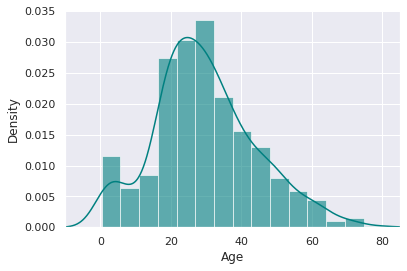

In [17]:
# plot histogram of age to determine its distribution
ax = train_x_logi["Age"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
train_x_logi["Age"].plot(kind='density', color='teal')
ax.set(xlabel='Age')
plt.xlim(-10,85)
plt.show()
# Since age distribution is right skewed, use median instead of mean to fill missing values

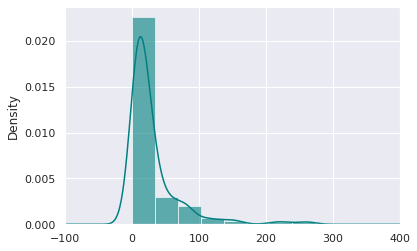

In [18]:
# plot histogram of age to determine its distribution
fx = train_x_logi["Fare"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
train_x_logi["Fare"].plot(kind='density', color='teal')
ax.set(xlabel='Fare')
plt.xlim(-100, 400)
plt.show()

In [19]:
# Label encode predictors with null values
#train_x_logi.fillna(train_x_logi["Fare"].mean(skipna=True),inplace=True)
test_x_logi.fillna(test_x_logi["Fare"].mean(skipna=True), inplace=True)
    
train_x_logi["Age"].fillna(train["Age"].median(skipna=True), inplace=True)
test_x_logi["Age"].fillna(test["Age"].median(skipna=True), inplace=True)

In [20]:
sp.stats.skew(train_x_logi["Fare"], axis=0, bias=True) 
# Apply log transformation on "Fare" since it is slightly skewed
train_x_logi["Fare"] = np.log1p(train_x_logi["Fare"])
test_x_logi["Fare"] = np.log1p(test_x_logi["Fare"])

In [21]:
sp.stats.skew(train_x_logi["Fare"], axis=0, bias=True) 

0.39426283638993376

## Ensemble from XGBClassifier Model and Logistic Regression Model

In [22]:
# Ensemble
model_lr = LogisticRegression(solver='lbfgs', max_iter=300)
model_lr.fit(train_x_logi, train_y)
pred_lr = model_lr.predict_proba(test_x_logi)[:, 1]

pred_ensem = pred * 0.8 + pred_lr * 0.2
pred_label_ensem = np.where(pred > 0.5, 1, 0)

## Submission

In [ ]:
submission = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': pred_label_ensem})
submission.to_csv('submission.csv', index=False)